# James Griffin 
## homework 4 

In [562]:
#importing a bunch of stuff 

import datetime
import gc
import numpy as np
import os
import operator
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
sns.set_palette(sns.color_palette('hls', 7))

from statistics import mean

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold
import random 
from random import sample

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from collections import Counter
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV

In [563]:
#importing training data, as train_df 

train_df = pd.read_csv("costa_rica_train.csv")
train_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [564]:
test_df = pd.read_csv("costa_rica_test.csv")
test_df.head()


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


looks like my training data has the column of target included, this looks to be my outcome variable from the data description on kaggle.  1 was extreme poverty, 2 is moderate, 3 is vulnerable and 4 is non vulnerable,  

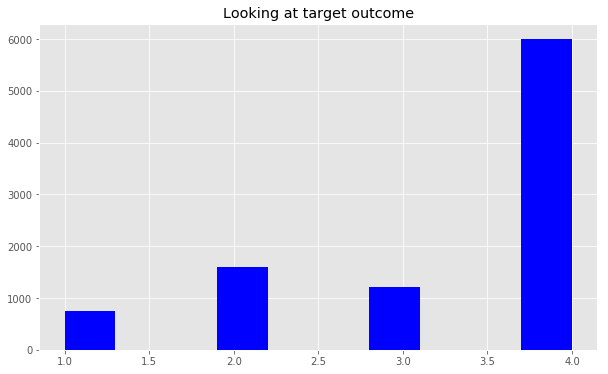

In [565]:
# to get a better look at my outcome variable, I will just plot it 

plt.style.use(style = 'ggplot')
plt.rcParams['figure.figsize'] = (10,6)

fig = plt.figure()
plt.hist(train_df.Target, color = 'blue')
plt.title('Looking at target outcome')

plt.show()

ok thinking out loud for a second, these are categorical variables, however they are ordinal, so we can say that our data is indeed skewed, but how do we deal with ordinal skewed data... ok well, we'll come back to this, for now, lets get the data clean

resample the data, over sample or under sample packages that we can use will be discussed in class 

In [566]:
#creating a target variable because I will have to drop the
#outcome variable when I run my train set 

y = train_df['Target']

In [567]:
# looking at nulls in training 

nulls_train = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)[:10])

print(nulls_train)

print(train_df.shape)

                   0
rez_esc         7928
v18q1           7342
v2a1            6860
meaneduc           5
SQBmeaned          5
techozinc          0
techoentrepiso     0
techocane          0
techootro          0
cielorazo          0
(9557, 143)


In [568]:
print(train_df['rez_esc'].head())

0    NaN
1    NaN
2    NaN
3    1.0
4    NaN
Name: rez_esc, dtype: float64


Ok so rez_esc is the number of years someone is behind in school, because I don't think it is likely that the NAN values should be zero, I am going to drop this column, additionally, out of 9557 data points we're missing almost 8000.

vl18q1 is the number of tablets in the home, although I don't think that would be highly correlated with poverety level, I will fill the NA values with 0, because that is more accurate than dropping 

v2a1 is the monthly rent payment, this one I am torn on, I could fill the NA with zeros, meaning that all of these people probably owned their own homes.  I don't know how strong of an assumption that is, will investigate further to see if other data indicates as to the rate of home ownership. 

For the meanduc, that is the mean years of education of adults 18+, I will fill in those missing points with the mean of whatever target they correspond to, and do the same for SQBmeaned, which is the square of the mean years of education of adults >= 18. They are probably the same 5 observation points, but thats my plan. 


In [569]:
print(train_df.v18q1.describe())


# ok I need to fill the missing values with 0 

count    2215.000000
mean        1.404063
std         0.763131
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: v18q1, dtype: float64


In [570]:
train_df['v18q1'] = train_df['v18q1'].replace(np.nan, 0)

#another easier syntax 
# train_df.v18q1 = train_df.v18q1.fillna(0)

print(train_df.v18q1.describe())

# ok looks like that all worked 

count    9557.000000
mean        0.325416
std         0.697118
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: v18q1, dtype: float64


Ok the data description gives several categories for home ownership, to make sure that I'm not comprimising the data with my assumption of home ownership, I will graph these to visualize and see if my assumption is valid. 

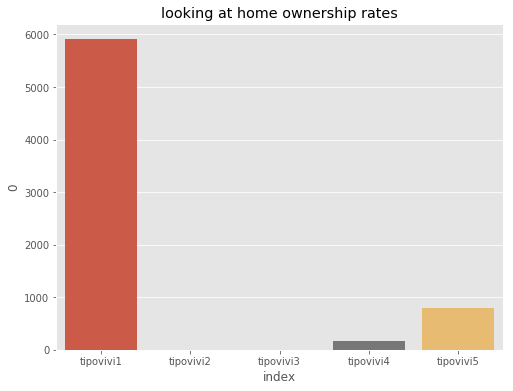

In [571]:
own_home = ['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']

#line provides the index for the new data set 
own_data = train_df.loc[train_df['v2a1'].isnull(), own_home].sum()
own_data = own_data.reset_index()
f, ax = plt.subplots(figsize=(8, 6))

plot = sns.barplot(x = 'index', y = 0 , data = own_data)

plt.title("looking at home ownership rates")

plt.show()



In [572]:
## ask nelson exactly what each line is doing 

Awesome, so it looks like the vast majority of the data do own their own home, so the assuption based on my gut is well founded in the data, I will therefore fill the empty values with 0 because that keeps the integrety of the data and actually paints a more accurate picture. 

In [573]:
#print(train_df.rez_esc.head())

#print(train_df.isnull().sum())

In [574]:
train_df['v2a1'] = train_df['v2a1'].replace(np.nan, 0)

#dropping columns with lots of missing data 

train_df.drop(axis = 1, columns = ['rez_esc'], inplace = True)

#CAN modify drop command by putting berackets next to columns and dropping a list of columns 


nulls = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)[:10])

print(nulls)

print(train_df.shape)

             0
SQBmeaned    5
meaneduc     5
Target       0
abastaguano  0
sanitario2   0
sanitario1   0
coopele      0
noelec       0
planpri      0
public       0
(9557, 142)


In [575]:
#awesome, got rid of those columns and filled in the data,
#I want to see what other missing data points I have
# and fill in values

nulls_df = train_df[train_df.isnull().any(axis=1)]

print(nulls_df)

                Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  \
1291  ID_bd8e11b0f       0.0       0      7       0     1       1     0   
1840  ID_46ff87316  110000.0       0      1       0     1       1     0   
1841  ID_69f50bf3e  110000.0       0      1       0     1       1     0   
2049  ID_db3168f9f  180000.0       0      3       0     1       1     0   
2050  ID_2a7615902  180000.0       0      3       0     1       1     0   

      v18q1  r4h1   ...    SQBescolari  SQBage  SQBhogar_total  SQBedjefe  \
1291    0.0     0   ...            100     324               1          0   
1840    0.0     0   ...             36     324               4         16   
1841    0.0     0   ...             16     324               4         16   
2049    0.0     0   ...            144     361               4        144   
2050    0.0     0   ...            144     361               4        144   

      SQBhogar_nin  SQBovercrowding  SQBdependency  SQBmeaned  agesq  Target  
1291   

ok so there are only 5 rows in this data frame, which tells me that missing values come from the same rows. since there are only 5 missing values, I will just fill them with the average of their respective columns.  If there were more data points missing, it would be wise to fill with a condtitional mean and partition your columns that are highly correlated to create a more realistic training data  

In [576]:
## Which numeric columns are correlated with target
numeric_features = train_df.select_dtypes(include=[np.number])

corr = numeric_features.corr()

# The first five features are the most positively correlated Target
print("most  positively correlated columns")
print (corr['Target'].sort_values(ascending=False)[:7])


print("")

print("most negative corr ")
print (corr['Target'].sort_values(ascending=False)[-7:])

most  positively correlated columns
Target         1.000000
meaneduc       0.335203
cielorazo      0.304421
escolari       0.302305
SQBescolari    0.296577
eviv3          0.294222
epared3        0.292451
Name: Target, dtype: float64

most negative corr 
r4m1              -0.253163
SQBovercrowding   -0.258744
overcrowding      -0.289110
SQBhogar_nin      -0.311186
r4t1              -0.316745
hogar_nin         -0.328199
elimbasu5               NaN
Name: Target, dtype: float64


ugghh thats not very encouraging, the highest correlation was .335, i'm going to try and create a data frame of only the five missing rows and look at their mean education recieved, however the meaneduc are the columns that are missing, cielorazo is just 1 or 0, visually Here is a heat map of correlation 

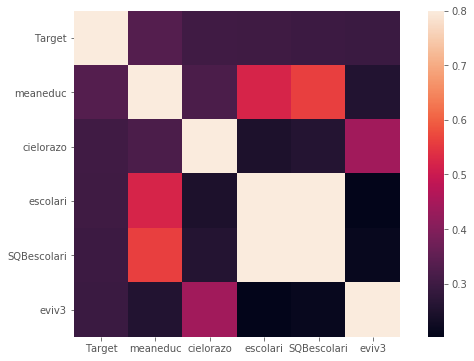

In [577]:
high_corr = train_df[["Target", "meaneduc", "cielorazo", 
                      "escolari", "SQBescolari", "eviv3"]]
corr_mat = high_corr.corr()
f, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(corr_mat,vmax=.8,square=True)

In [578]:
nulls_df.loc[:, ["escolari", "cielorazo", "SQBescolari", "eviv3"]]

## Ok so i think I will partition this into two groups, 1291, 2049 and 2050 into one group, and then 
# 1840 and 1841 into another group. and fill in the missing values with the conditiaonal
# mean where escolari >= 10 and eviv3 == 1 

,escolari,cielorazo,SQBescolari,eviv3
1291,10,1,100,1
1840,6,1,36,0
1841,4,1,16,0
2049,12,1,144,1
2050,12,1,144,1


Should have picked up on it earlier, but SQBescolari is just the squared value of the escolari, the number of years the head of houshold was in school.  So naturally if one is, the other will also be highly correlated with the target variable. 

In [579]:
train_df['meaneduc'] = train_df.groupby('escolari')['meaneduc'].transform(lambda x: x.fillna(x.median()))

train_df['SQBmeaned'] = (train_df.meaneduc)**2

OK now that my missing data is filled in and accurage, time to look at my categorical data. 


In [580]:
train_df.select_dtypes(include = "object").head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Since id and idhogar as unique identifiers, at first I had the inclination to leave them in, some IS 201 recolection wanted me to do that, however these columns do not give me any real information, and could potentially throw off the predictions if they are some how correlated with my target variable, so I will drop these ID columns.  

It looks like the other three have yes/no/ integer values. Data description says it is the number of members the household younger than 19, from the data description, it looks like 'yes' in each column can be replaced with a 1 

In the edjefe and edjefa, these are the number of years of education for the male and female head of households respectively, will fill these with 0 if no using a simple for loop 

In [581]:
#dictionary = {"no": 0, "yes":1}

#train_df.edjefe = train_df.replace(dictionary)

In [582]:
train_df.edjefe.head()

0    10
1    12
2    no
3    11
4    11
Name: edjefe, dtype: object

In [583]:
#train_df.select_dtypes(include = "object").head() 

In [584]:
#train_df.drop(axis = 1, columns = ['rez_esc'], inplace = True)

train_df.drop(["Id", "idhogar"],axis = 1,  inplace = True)


In [585]:
dictionary = {"no": 0, "yes":1}

train_df.edjefe = train_df.edjefe.replace(dictionary)

train_df.edjefa = train_df.edjefa.replace(dictionary)

train_df.dependency = train_df.dependency.replace(dictionary)

In [586]:
train_df.select_dtypes(include = "object").head()

,dependency,edjefe,edjefa
0,0,10,0
1,8,12,0
2,8,0,11
3,1,11,0
4,1,11,0


Awesome, so it looks like that worked for all of the categories with yes and no's 

# Feature Creation: 

# going to create a few variables to practice in preperation for the final project 

feature #1, will be the percentage of dependents in the home.  Often pooer families have a large number of children

feature #2 = home quality, will be an imput of floor, roof, running water, electricity, and if they burn or throw trash in river. 

In [587]:
train_df['child_per'] = train_df['hogar_nin'] / train_df['hogar_total']

train_df["home_qual"] = (train_df['abastaguadentro'] + train_df['public'] + train_df['planpri'] + train_df['coopele']
                      + train_df['energcocinar2'] + train_df['energcocinar3'] + train_df['eviv1'] + train_df['eviv2']
                      + train_df['eviv3']+ train_df['etecho1'] + train_df['etecho2']+ train_df['etecho3'])

In [588]:
print(train_df.child_per.describe())

print(train_df.home_qual.describe())

count    9557.000000
mean        0.301325
std         0.241194
min         0.000000
25%         0.000000
50%         0.333333
75%         0.500000
max         1.000000
Name: child_per, dtype: float64
count    9557.000000
mean        4.908967
std         0.328753
min         2.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: home_qual, dtype: float64


Just from looking at the descriptions of the features, I don't think they will be too highly correlated.  it looks like they are quite consistant across the data set, and have very narrow distributions. Will still include them below  but 

In [589]:
numeric_features = train_df.select_dtypes(include=[np.number])

corr = numeric_features.corr()

# The first five features are the most positively correlated Target
print("most  positively correlated columns")
print (corr['Target'].sort_values(ascending=False)[:10])


most  positively correlated columns
Target         1.000000
meaneduc       0.335126
cielorazo      0.304421
escolari       0.302305
SQBescolari    0.296577
eviv3          0.294222
epared3        0.292451
pisomoscer     0.280284
SQBmeaned      0.276518
paredblolad    0.261274
Name: Target, dtype: float64


yup, looks like the the features are not highly correlated 

# Model 1: Random Forest decision trees 

In [590]:
#splitting the data 
X_train, X_test, Y_train, Y_test,  = train_test_split(train_df, y, test_size = 0.2, random_state = 42)

In [591]:
param_dictionary = {'n_estimators': [1000]}
clf = RandomForestClassifier(n_jobs = -1, max_depth = 3, class_weight = 'balanced')
gs = GridSearchCV(clf, param_dictionary, scoring = 'f1_macro',n_jobs=-1, verbose = 2)
gs.fit(X_train, Y_train)

C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1_macro',
       verbose=2)

In [592]:
#looking at the results 
gs.cv_results_

C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\13855\Anaconda_Re_do\lib\site-p

{'mean_fit_time': array([1.42186443]),
 'std_fit_time': array([0.00542204]),
 'mean_score_time': array([0.32332325]),
 'std_score_time': array([0.00093012]),
 'param_n_estimators': masked_array(data=[1000],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 1000}],
 'split0_test_score': array([0.78915055]),
 'split1_test_score': array([0.83921002]),
 'split2_test_score': array([0.79532182]),
 'mean_test_score': array([0.80789087]),
 'std_test_score': array([0.02228668]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.81754143]),
 'split1_train_score': array([0.83493447]),
 'split2_train_score': array([0.81603786]),
 'mean_train_score': array([0.82283792]),
 'std_train_score': array([0.00857555])}

Hey that looks pretty good, it doesn't look like I'm over fitting, Similar scores for both training and testing data where sometimes the test is higher than the train and sometimes the train is higher than the test 

Looks like split number 2 gave me the best score for both training and testing, and my mean for my train was .84 and my mean for my test was .82, so feeling good about that. 


Will do a little hyper perameter tuning to see how this is doing 

In [593]:
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

#models = [rf, knn]
#for i in models:
#    test_clf(i)

#params = {'rf' : {'n_estimators' : np.arange(100,2000,100),
 #                 'criterion' : ['gini', 'entropy'],
  #                'min_samples_split' : np.arange(2, 5, 1),
   #               'max_features' : np.arange(10, 50, 10),
    #              'max_depth' : np.arange(3, 10, 1)}
     #    }

In [594]:

#def tune_params(clf, params):
 #   clf_rs = KNeighborsClassifier(clf, param_distributions = params, n_iter = 20, scoring = 'f1_macro', verbose=1)
  #  clf_rs.fit(X_train, Y_train)
   # clf_rs_pred = clf_rs.predict(X_test)
    #score = f1_score(y_test, clf_rs_pred, average = 'macro')
    #print('F1 Score: %s \n' %(score))
    #print('Best Parameters:',clf_rs.best_params_)

In [595]:
#Train models and make predictions
rf.fit(X_train, Y_train)
rf_pred = rf.predict(X_test)
#gnb.fit(X_train, Y_train)
#gnb_pred = gnb.predict(X_test)

C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [596]:
rf_report = classification_report(Y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           1       0.94      0.90      0.92       164
           2       0.90      0.96      0.93       311
           3       0.98      0.90      0.94       254
           4       0.99      1.00      1.00      1183

   micro avg       0.97      0.97      0.97      1912
   macro avg       0.95      0.94      0.95      1912
weighted avg       0.97      0.97      0.97      1912



Awesome, everything so far is indicating a well put together model 

# Second Model: K nearest neighbors 

In [597]:
data = train_df
#X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.20, random_state=42)
#already ran this line of code and dont want to do it twice 
#using the default state 42 that is how it is on the sk learn gradient description 


In [598]:
param_dictionary = {'n_estimators': [1000]}
param_dictionary = {'algorithm': ["ball_tree", "kd_tree"]}
clf = KNeighborsClassifier(n_neighbors = 3, )
gs = GridSearchCV(clf, param_dictionary, scoring = 'f1_macro',n_jobs=-1, verbose = 2)
gs.fit(X_train, Y_train)


C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.6s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'algorithm': ['ball_tree', 'kd_tree']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=2)

In [599]:
gs.cv_results_

C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\13855\Anaconda_Re_do\lib\site-p

{'mean_fit_time': array([0.11436033, 0.13763245]),
 'std_fit_time': array([0.00893331, 0.01800665]),
 'mean_score_time': array([0.38563553, 0.38762983]),
 'std_score_time': array([0.04196949, 0.01143885]),
 'param_algorithm': masked_array(data=['ball_tree', 'kd_tree'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'algorithm': 'ball_tree'}, {'algorithm': 'kd_tree'}],
 'split0_test_score': array([0.33997622, 0.34059122]),
 'split1_test_score': array([0.3465278, 0.3465278]),
 'split2_test_score': array([0.35507905, 0.35507905]),
 'mean_test_score': array([0.34719144, 0.34739657]),
 'std_test_score': array([0.00618373, 0.00594663]),
 'rank_test_score': array([2, 1]),
 'split0_train_score': array([0.61755408, 0.61755408]),
 'split1_train_score': array([0.60795061, 0.60795061]),
 'split2_train_score': array([0.61527424, 0.61527424]),
 'mean_train_score': array([0.61359298, 0.61359298]),
 'std_train_score': array([0.00409688, 0.00409688])

In [600]:
#params = {'knn' : {'n_estimators' : np.arange(100,2000,100),
 #                 'criterion' : ['gini', 'entropy'],
  #                'min_samples_split' : np.arange(2, 5, 1),
   #               'max_features' : np.arange(10, 50, 10),
    #              'max_depth' : np.arange(3, 10, 1)}
     #    }


#def tune_params(clf, params):
 #   clf_rs = RandomizedSearchCV(clf, param_distributions = params, n_iter = 20, scoring = 'f1_macro', verbose=1)
  #  clf_rs.fit(x_resampled, y_resampled)
   # clf_rs_pred = clf_rs.predict(x_test)
    #score = f1_score(y_test, clf_rs_pred, average = 'macro')
    #print('F1 Score: %s \n' %(score))
    #print('Best Parameters:',clf_rs.best_params_)

In [601]:
#Train models and make predictions
knn.fit(X_train, Y_train)
knn_pred = rf.predict(X_test)
#gnb.fit(X_train, Y_train)
#gnb_pred = gnb.predict(X_test

In [603]:
knn_report = classification_report(Y_test, knn_pred)
print(knn_report)

              precision    recall  f1-score   support

           1       0.94      0.90      0.92       164
           2       0.90      0.96      0.93       311
           3       0.98      0.90      0.94       254
           4       0.99      1.00      1.00      1183

   micro avg       0.97      0.97      0.97      1912
   macro avg       0.95      0.94      0.95      1912
weighted avg       0.97      0.97      0.97      1912



That is a lot of over fitting right there, my train scores are in the 60s, but the test scores are in the 30s, which is not good at all, but it means that I have high varience in this model.  To address these problems, I would need to have more training data, less features or a less complexe model.  

## Ok so going from here I am going to over sample my target data to see if I can get different results.  

I wonder if part of the problem of the k nearest neighbors is the skewness of my outcome variable.  It is also entirely possible that the reason my random forest did so well, is it just said, put everything in Low Risk category 4. because, that was the dominant category by quite a long way.  If i was going to assign people to a value, I would be pretty good if I just said that the were all in that category, so I think this will be a good sanity check to make sure that I am on the right track. 

First step is to create a new training set with balanced data 


In [604]:
ros = RandomOverSampler(random_state=0)

x_resampled, y_resampled = ros.fit_resample(X_train, Y_train)

Text(0.5, 0, 'Poverty Level')

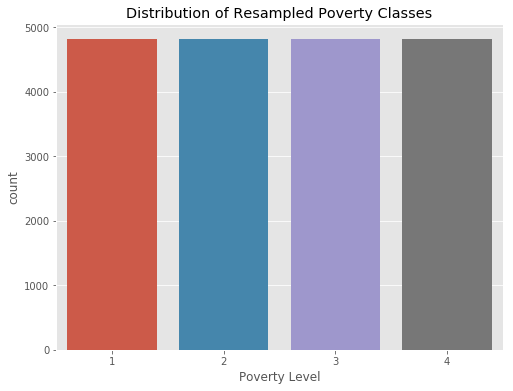

In [605]:
f, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y_resampled)
plt.title('Distribution of Resampled Poverty Classes')
plt.xlabel('Poverty Level')


Ok, now that the poverty levels are all equal, I am going to run my Random Forest and K Nearest Neighbors again to see what kind of difference it makes 

In [606]:
X_train, X_test, Y_train, Y_test,  = train_test_split(train_df, y, test_size = 0.2, random_state = 42)

param_dictionary = {'n_estimators': [1000]}
clf = RandomForestClassifier(n_jobs = -1, max_depth = 3, class_weight = 'balanced')
gs = GridSearchCV(clf, param_dictionary, scoring = 'f1_macro',n_jobs=-1, verbose = 2)
gs.fit(X_train, Y_train)

C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1_macro',
       verbose=2)

In [607]:
#looking at the results 
gs.cv_results_

C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\13855\Anaconda_Re_do\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\13855\Anaconda_Re_do\lib\site-p

{'mean_fit_time': array([1.45710333]),
 'std_fit_time': array([0.00990767]),
 'mean_score_time': array([0.32662837]),
 'std_score_time': array([0.00453295]),
 'param_n_estimators': masked_array(data=[1000],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 1000}],
 'split0_test_score': array([0.85512833]),
 'split1_test_score': array([0.83476497]),
 'split2_test_score': array([0.80386538]),
 'mean_test_score': array([0.83126272]),
 'std_test_score': array([0.02107467]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.86944464]),
 'split1_train_score': array([0.82502431]),
 'split2_train_score': array([0.82300715]),
 'mean_train_score': array([0.8391587]),
 'std_train_score': array([0.02143122])}

In [608]:

print('----- ORIGINAL output -----\n')
print(rf_report)

rf_resampled = rf
rf_resampled.fit(x_resampled, y_resampled)
rf_resampled_pred = rf_resampled.predict(X_test)
rf_resampled_report = classification_report(Y_test, rf_resampled_pred)
print('----- RESAMPLING CLASSIFICATION REPORT -----\n')
print(rf_resampled_report)

----- ORIGINAL output -----

              precision    recall  f1-score   support

           1       0.94      0.90      0.92       164
           2       0.90      0.96      0.93       311
           3       0.98      0.90      0.94       254
           4       0.99      1.00      1.00      1183

   micro avg       0.97      0.97      0.97      1912
   macro avg       0.95      0.94      0.95      1912
weighted avg       0.97      0.97      0.97      1912

----- RESAMPLING CLASSIFICATION REPORT -----

              precision    recall  f1-score   support

           1       0.96      0.93      0.95       164
           2       0.93      0.95      0.94       311
           3       0.96      0.89      0.93       254
           4       0.98      1.00      0.99      1183

   micro avg       0.97      0.97      0.97      1912
   macro avg       0.96      0.94      0.95      1912
weighted avg       0.97      0.97      0.97      1912



Awesome, this is really encouraging, it looks like even with the new sampled data, I got even better and my scores do not apear to be over fitting 

Going to visualize the most important columns, create a data frame and fill it 

In [612]:
important_features = pd.DataFrame(columns = ['Variable', 'Coef'])
important_features['Variable'] 
important_features['Coef'] = abs(rf_resampled.important_features)
important_features.sort_values(by = 'Coef', ascending = False, inplace = True)
important_features = important_features[0:15]

AttributeError: 'RandomForestClassifier' object has no attribute 'important_features'